In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def trans_sig_status(row):
    if row.trans_human_status == "significant trans effect" and row.trans_mouse_status == "significant trans effect":
        return "sig_both"
    elif row.trans_human_status == "significant trans effect" and row.trans_mouse_status == "no trans effect":
        return "sig_human"
    elif row.trans_human_status == "no trans effect" and row.trans_mouse_status == "significant trans effect":
        return "sig_mouse"
    else:
        return "not_sig_both"

## variables

In [6]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


## 2. filter data

In [8]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2916

In [9]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1628

In [10]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1617

In [11]:
# data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
# len(data_filt_tile1)

In [12]:
# data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
# len(data_filt_tile1_sp)

In [13]:
# data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
# len(data_filt_tile2)

In [14]:
# data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
# len(data_filt_tile2_sp)

## 3. count of trans effects

In [15]:
trans_order = ["no trans effect", "significant trans effect"]
trans_pal = {"no trans effect": "gray", "significant trans effect": "black"}

det_order = ["trans effect\n(higher in human)", "trans effect\n(higher in mouse)"]
complete_pal = {"trans effect\n(higher in human)": sns.color_palette("Set2")[1],
                "trans effect\n(higher in mouse)": sns.color_palette("Set2")[0]}
det_pal = {"trans effect\n(higher in human)": sns.light_palette(sns.color_palette("Set2")[1])[2],
           "trans effect\n(higher in mouse)": sns.light_palette(sns.color_palette("Set2")[0])[2]}

In [16]:
# dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
# titles = ["both tiles", "tile1 only", "tile2 only"]
# labels = ["both_tiles", "tile1_only", "tile2_only"]

In [17]:
# for df, title, label in zip(dfs, titles, labels):
    
#     fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

#     sns.countplot(data=df, x="trans_status_one", palette=trans_pal, order=trans_order, linewidth=2, 
#                   edgecolor=trans_pal.values(), ax=ax)
#     ax.set_xticklabels(["no trans effect", "trans effect"], va="top", ha="right", rotation=50)
#     ax.set_xlabel("")
#     ax.set_title(title)
    
#     tot = 0
#     for i, l in enumerate(trans_order):
#         n = len(df[df["trans_status_one"] == l])
#         tot += n
#         ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
#     print("percent trans sig: %s" % (n/tot))

#     plt.show()
#     fig.savefig("count_trans_status.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

In [18]:
df = data_filt_sp

percent trans sig: 0.1805813234384663


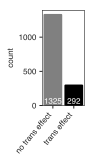

In [19]:
fig, ax = plt.subplots(figsize=(0.75, 1.75), nrows=1, ncols=1)

sns.countplot(data=df, x="trans_status_one", palette=trans_pal, order=trans_order, linewidth=2, 
              edgecolor=trans_pal.values(), ax=ax)
ax.set_xticklabels(["no trans effect", "trans effect"], va="top", ha="right", rotation=50)
ax.set_xlabel("")

tot = 0
for i, l in enumerate(trans_order):
    n = len(df[df["trans_status_one"] == l])
    tot += n
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
print("percent trans sig: %s" % (n/tot))

plt.show()
fig.savefig("count_trans_status.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 4. plot trans effect sizes between human and mouse

In [20]:
# for df, title, label in zip(dfs, titles, labels):
#     df["trans_sig_status"] = df.apply(trans_sig_status, axis=1)
#     # plot effect size agreement b/w the two seqs
#     fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

#     sig_human = df[df["trans_sig_status"] == "sig_human"]
#     sig_mouse = df[df["trans_sig_status"] == "sig_mouse"]
#     sig_both = df[df["trans_sig_status"] == "sig_both"]
#     not_sig = df[df["trans_sig_status"] == "not_sig_both"]

#     ax.scatter(not_sig["logFC_trans_human"], not_sig["logFC_trans_mouse"], s=10, alpha=0.75, 
#                color="gray", linewidths=0.5, edgecolors="white")
#     ax.scatter(sig_human["logFC_trans_human"], sig_human["logFC_trans_mouse"], s=10, alpha=0.75, 
#                color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
#     ax.scatter(sig_mouse["logFC_trans_human"], sig_mouse["logFC_trans_mouse"], s=10, alpha=0.75, 
#                color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")
#     ax.scatter(sig_both["logFC_trans_human"], sig_both["logFC_trans_mouse"], s=12, alpha=1, 
#                color="black", linewidths=0.5, edgecolors="white")

#     plt.xlabel("human seq. trans effect size")
#     plt.ylabel("mouse seq. trans effect size")

#     ax.axhline(y=0, color="black", linestyle="dashed")
#     ax.axvline(x=0, color="black", linestyle="dashed")
#     ax.set_xlim((-3, 2))
#     ax.set_ylim((-2, 2.5))

#     # annotate corr
#     no_nan = df[(~pd.isnull(df["logFC_trans_human"])) & (~pd.isnull(df["logFC_trans_mouse"]))]
#     r, p = spearmanr(no_nan["logFC_trans_human"], no_nan["logFC_trans_mouse"])
#     ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
#             transform=ax.transAxes)
#     fig.savefig("trans_effect_bw_seqs_scatter.sig_status_color.%s.pdf" % label, dpi="figure", bbox_inches="tight")

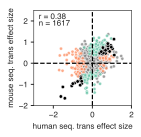

In [21]:
df["trans_sig_status"] = df.apply(trans_sig_status, axis=1)
# plot effect size agreement b/w the two seqs
fig, ax = plt.subplots(figsize=(1.75, 1.75), nrows=1, ncols=1)

sig_human = df[df["trans_sig_status"] == "sig_human"]
sig_mouse = df[df["trans_sig_status"] == "sig_mouse"]
sig_both = df[df["trans_sig_status"] == "sig_both"]
not_sig = df[df["trans_sig_status"] == "not_sig_both"]

ax.scatter(not_sig["logFC_trans_human"], not_sig["logFC_trans_mouse"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_human["logFC_trans_human"], sig_human["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse["logFC_trans_human"], sig_mouse["logFC_trans_mouse"], s=10, alpha=0.75, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")
ax.scatter(sig_both["logFC_trans_human"], sig_both["logFC_trans_mouse"], s=12, alpha=1, 
           color="black", linewidths=0.5, edgecolors="white")

plt.xlabel("human seq. trans effect size")
plt.ylabel("mouse seq. trans effect size")

ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xlim((-3, 2))
ax.set_ylim((-2, 2.5))

# annotate corr
no_nan = df[(~pd.isnull(df["logFC_trans_human"])) & (~pd.isnull(df["logFC_trans_mouse"]))]
r, p = spearmanr(no_nan["logFC_trans_human"], no_nan["logFC_trans_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("trans_effect_bw_seqs_scatter.sig_status_color.pdf", dpi="figure", bbox_inches="tight")

## 5. effect size differences across biotypes

In [22]:
min_switch_order = ["CAGE turnover - eRNA", "CAGE turnover - lncRNA", "CAGE turnover - mRNA", 
                    "eRNA", "lncRNA", "mRNA"]
min_switch_pal = {"CAGE turnover - eRNA": sns.color_palette("Set2")[2], 
                  "CAGE turnover - lncRNA": sns.color_palette("Set2")[2],
                  "CAGE turnover - mRNA": sns.color_palette("Set2")[2],
                  "eRNA": sns.color_palette("Set2")[7], 
                  "lncRNA": sns.color_palette("Set2")[7], 
                  "mRNA": sns.color_palette("Set2")[7]}

In [23]:
# for df, title, label in zip(dfs, titles, labels):
#     df["abs_logFC_trans"] = np.abs(df["logFC_trans_one"])
#     #df = df[df["native_status"] == "significant native effect"]

#     fig = plt.figure(figsize=(2.5, 2))
#     ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_trans", 
#                      flierprops = dict(marker='o', markersize=5), 
#                      order=min_switch_order, color=sns.color_palette("Set2")[2])
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(min_switch_order, rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("trans effect size")
#     ax.set_title(title)

#     for i, l in enumerate(min_switch_order):
#         sub = df[df["biotype_switch_minimal"] == l]
#         n = len(sub)
#         print("%s median eff size: %s" % (l, sub["abs_logFC_trans"].median()))
#         color = sns.color_palette("Set2")[2]
#         ax.annotate(str(n), xy=(i, -0.2), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=color, size=fontsize)

#     ax.set_ylim((-0.3, 1.75))
#     ax.axvline(x=2.5, linestyle="dashed", color="black")

#     plt.show()
#     fig.savefig("trans_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

In [24]:
# for df, title, label in zip(dfs, titles, labels):
#     df["abs_logFC_trans"] = np.abs(df["logFC_trans_one"])

#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_trans", 
#                      flierprops = dict(marker='o', markersize=5), 
#                      order=min_switch_order, palette=min_switch_pal)
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("trans effect size")
#     ax.set_title(title)

#     for i, l in enumerate(min_switch_order):
#         sub = df[df["biotype_switch_minimal"] == l]
#         n = len(sub)
#         print("%s median eff size: %s" % (l, sub["abs_logFC_trans"].median()))
#         color = min_switch_pal[l]
#         ax.annotate(str(n), xy=(i, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=color, size=fontsize)
        
#     ### pvals ###
#     vals1 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - eRNA"]["abs_logFC_trans"])
#     vals2 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - lncRNA"]["abs_logFC_trans"])
#     vals3 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - mRNA"]["abs_logFC_trans"])
#     vals4 = np.asarray(df[df["biotype_switch_minimal"] == "eRNA"]["abs_logFC_trans"])
#     vals5 = np.asarray(df[df["biotype_switch_minimal"] == "lncRNA"]["abs_logFC_trans"])
#     vals6 = np.asarray(df[df["biotype_switch_minimal"] == "mRNA"]["abs_logFC_trans"])
    
#     vals1 = vals1[~np.isnan(vals1)]
#     vals2 = vals2[~np.isnan(vals2)]
#     vals3 = vals3[~np.isnan(vals3)]
#     vals4 = vals4[~np.isnan(vals4)]
#     vals5 = vals5[~np.isnan(vals5)]
#     vals6 = vals6[~np.isnan(vals6)]
    
#     _, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
#     _, pval13 = stats.mannwhitneyu(vals1, vals3, alternative="two-sided", use_continuity=False)
#     _, pval23 = stats.mannwhitneyu(vals2, vals3, alternative="two-sided", use_continuity=False)
#     _, pval45 = stats.mannwhitneyu(vals4, vals5, alternative="two-sided", use_continuity=False)
#     _, pval46 = stats.mannwhitneyu(vals4, vals6, alternative="two-sided", use_continuity=False)
#     _, pval56 = stats.mannwhitneyu(vals5, vals6, alternative="two-sided", use_continuity=False)
    
#     print(pval12)
#     print(pval13)
#     print(pval23)
#     print(pval45)
#     print(pval46)
#     print(pval56)
    
#     annotate_pval(ax, 0.2, 0.8, 1.25, 0, 1.25, pval12, fontsize-1)
#     annotate_pval(ax, 1.2, 1.8, 1.25, 0, 1.25, pval13, fontsize-1)
#     annotate_pval(ax, 0, 2, 1.75, 0, 1.75, pval23, fontsize-1)
#     annotate_pval(ax, 3.2, 3.8, 1.25, 0, 1.25, pval45, fontsize-1)
#     annotate_pval(ax, 4.2, 4.8, 1.25, 0, 1.25, pval56, fontsize-1)
#     annotate_pval(ax, 3, 5, 1.75, 0, 1.75, pval46, fontsize-1)

#     ax.set_ylim((-0.4, 2))
#     ax.axvline(x=2.5, linestyle="dashed", color="black")

#     plt.show()
#     fig.savefig("trans_minimal_biotype_switch_effectsize_boxplot.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA median eff size: 0.4396482228057971
CAGE turnover - lncRNA median eff size: 0.3842424353650375
CAGE turnover - mRNA median eff size: 0.361932620313412
eRNA median eff size: 0.43517941248019
lncRNA median eff size: 0.346584858496042
mRNA median eff size: 0.369411147226681
0.266700164486
0.271636861308
0.620161872639
0.0268142235742
0.0242620661319
0.757654136282


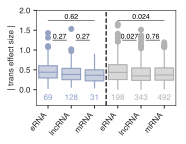

In [25]:
df["abs_logFC_trans"] = np.abs(df["logFC_trans_one"])

fig = plt.figure(figsize=(2.5, 1.75))
ax = sns.boxplot(data=df, x="biotype_switch_minimal", y="abs_logFC_trans", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=min_switch_order, palette=min_switch_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel(r"$\vert$ trans effect size $\vert$")

for i, l in enumerate(min_switch_order):
    sub = df[df["biotype_switch_minimal"] == l]
    n = len(sub)
    print("%s median eff size: %s" % (l, sub["abs_logFC_trans"].median()))
    color = min_switch_pal[l]
    ax.annotate(str(n), xy=(i, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

### pvals ###
vals1 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - eRNA"]["abs_logFC_trans"])
vals2 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - lncRNA"]["abs_logFC_trans"])
vals3 = np.asarray(df[df["biotype_switch_minimal"] == "CAGE turnover - mRNA"]["abs_logFC_trans"])
vals4 = np.asarray(df[df["biotype_switch_minimal"] == "eRNA"]["abs_logFC_trans"])
vals5 = np.asarray(df[df["biotype_switch_minimal"] == "lncRNA"]["abs_logFC_trans"])
vals6 = np.asarray(df[df["biotype_switch_minimal"] == "mRNA"]["abs_logFC_trans"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]
vals3 = vals3[~np.isnan(vals3)]
vals4 = vals4[~np.isnan(vals4)]
vals5 = vals5[~np.isnan(vals5)]
vals6 = vals6[~np.isnan(vals6)]

_, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
_, pval13 = stats.mannwhitneyu(vals1, vals3, alternative="two-sided", use_continuity=False)
_, pval23 = stats.mannwhitneyu(vals2, vals3, alternative="two-sided", use_continuity=False)
_, pval45 = stats.mannwhitneyu(vals4, vals5, alternative="two-sided", use_continuity=False)
_, pval46 = stats.mannwhitneyu(vals4, vals6, alternative="two-sided", use_continuity=False)
_, pval56 = stats.mannwhitneyu(vals5, vals6, alternative="two-sided", use_continuity=False)

print(pval12)
print(pval13)
print(pval23)
print(pval45)
print(pval46)
print(pval56)

annotate_pval(ax, 0.2, 0.8, 1.25, 0, 1.25, pval12, fontsize-1)
annotate_pval(ax, 1.2, 1.8, 1.25, 0, 1.25, pval13, fontsize-1)
annotate_pval(ax, 0, 2, 1.75, 0, 1.75, pval23, fontsize-1)
annotate_pval(ax, 3.2, 3.8, 1.25, 0, 1.25, pval45, fontsize-1)
annotate_pval(ax, 4.2, 4.8, 1.25, 0, 1.25, pval56, fontsize-1)
annotate_pval(ax, 3, 5, 1.75, 0, 1.75, pval46, fontsize-1)

ax.set_ylim((-0.4, 2))
ax.axvline(x=2.5, linestyle="dashed", color="black")

plt.show()
fig.savefig("trans_minimal_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [26]:
def cage_status(row):
    if "CAGE turnover" in row.biotype_switch_minimal:
        return "turnover"
    else:
        return "conserved"

In [27]:
def one_biotype(row):
    if row.minimal_biotype_hg19 == "no CAGE activity":
        return row.minimal_biotype_mm9
    elif row.biotype_switch_minimal == "biotype switch":
        return "biotype switch"
    else:
        return row.minimal_biotype_hg19

In [28]:
pal = {"conserved": sns.color_palette("Set2")[7], "turnover": sns.color_palette("Set2")[2]}

In [29]:
# for df, title, pltname in zip(dfs, titles, labels):
#     df["abs_logFC_trans"] = np.abs(df["logFC_trans_one"])
#     df["cage_status"] = df.apply(cage_status, axis=1)
#     df["one_biotype"] = df.apply(one_biotype, axis=1)
    
#     fig = plt.figure(figsize=(2.75, 1.5))

#     ax = sns.boxplot(data=df, x="one_biotype", y="abs_logFC_trans", hue="cage_status",
#                      flierprops = dict(marker='o', markersize=5),
#                      order=["eRNA", "lncRNA", "mRNA"], hue_order=["turnover", "conserved"], palette=pal)
#     mimic_r_boxplot(ax)

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("trans effect size")
#     plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

#     ys = [0.75, 0.75, 0.75]
#     for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
#         sub = df[df["one_biotype"] == label]
#         sub1 = sub[sub["cage_status"] == "turnover"]
#         sub2 = sub[sub["cage_status"] == "conserved"]

#         vals1 = np.asarray(sub1["abs_logFC_trans"])
#         vals2 = np.asarray(sub2["abs_logFC_trans"])

#         vals1 = vals1[~np.isnan(vals1)]
#         vals2 = vals2[~np.isnan(vals2)]

#         u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
#         print(pval)

#         if pval >= 0.05:
#             annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)
#         else:
#             annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)

#         n1 = len(vals1)
#         n2 = len(vals2)

#         ax.annotate(str(n1), xy=(i-0.2, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=pal["turnover"], size=fontsize)
#         ax.annotate(str(n2), xy=(i+0.2, -0.3), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color=pal["conserved"], size=fontsize)

#     ax.set_ylim((-0.4, 2))
#     ax.set_title(title)
#     fig.savefig("trans_effect_biotype_sep_cage.%s.pdf" % pltname, dpi="figure", bbox_inches="tight")

0.978335731354
0.531132369727
0.862828353572


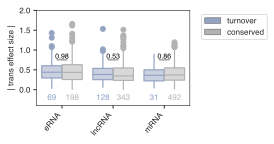

In [30]:
df["abs_logFC_trans"] = np.abs(df["logFC_trans_one"])
df["cage_status"] = df.apply(cage_status, axis=1)
df["one_biotype"] = df.apply(one_biotype, axis=1)

fig = plt.figure(figsize=(2.75, 1.75))

ax = sns.boxplot(data=df, x="one_biotype", y="abs_logFC_trans", hue="cage_status",
                 flierprops = dict(marker='o', markersize=5),
                 order=["eRNA", "lncRNA", "mRNA"], hue_order=["turnover", "conserved"], palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel(r"$\vert$ trans effect size $\vert$")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ys = [0.75, 0.75, 0.75]
for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
    sub = df[df["one_biotype"] == label]
    sub1 = sub[sub["cage_status"] == "turnover"]
    sub2 = sub[sub["cage_status"] == "conserved"]

    vals1 = np.asarray(sub1["abs_logFC_trans"])
    vals2 = np.asarray(sub2["abs_logFC_trans"])

    vals1 = vals1[~np.isnan(vals1)]
    vals2 = vals2[~np.isnan(vals2)]

    u, pval = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)
    print(pval)

    if pval >= 0.05:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)
    else:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize-1)

    n1 = len(vals1)
    n2 = len(vals2)

    ax.annotate(str(n1), xy=(i-0.2, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=pal["turnover"], size=fontsize)
    ax.annotate(str(n2), xy=(i+0.2, -0.3), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=pal["conserved"], size=fontsize)

ax.set_ylim((-0.4, 2))
fig.savefig("trans_effect_biotype_sep_cage.pdf", dpi="figure", bbox_inches="tight")

## 6. percent sig across biotypes

In [31]:
# for df, title, label in zip(dfs, titles, labels):

#     tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     sig = df[df["trans_status_one"] != "no trans effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
#     clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
#     clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
    
#     fig = plt.figure(figsize=(2.5, 1.5))
#     ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
#                      order=min_switch_order, color=sns.color_palette("Set2")[2])

#     ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
#     ax.set_xlabel("")
#     ax.set_ylabel("% of seq. pairs with\ntrans effects")
#     ax.set_title(title)
#     ax.axvline(x=2.5, linestyle="dashed", color="black")
    
#     for i, l in enumerate(min_switch_order):
#         sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
#         print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
#         n = sub["hg19_id_x"].iloc[0]
#         ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
#                     textcoords="offset pixels", ha='center', va='bottom', 
#                     color="white", size=fontsize)
    
#     plt.show()
#     fig.savefig("perc_sig_trans_minimal_biotype_switch.%s.pdf" % label, dpi="figure", bbox_inches="tight")
#     plt.close()

CAGE turnover - eRNA perc sig: 24.6376811594
CAGE turnover - lncRNA perc sig: 16.40625
CAGE turnover - mRNA perc sig: 19.3548387097
eRNA perc sig: 22.2222222222
lncRNA perc sig: 18.9504373178
mRNA perc sig: 15.8536585366


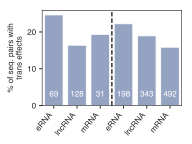

In [32]:
tots = df.groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
sig = df[df["trans_status_one"] != "no trans effect"].groupby("biotype_switch_minimal")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_minimal", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100

fig = plt.figure(figsize=(2.5, 1.75))
ax = sns.barplot(data=clean_sig, x="biotype_switch_minimal", y="percent_sig", 
                 order=min_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA", "eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of seq. pairs with\ntrans effects")
ax.axvline(x=2.5, linestyle="dashed", color="black")

for i, l in enumerate(min_switch_order):
    sub = clean_sig[clean_sig["biotype_switch_minimal"] == l]
    print("%s perc sig: %s" % (l, sub["percent_sig"].iloc[0]))
    n = sub["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)

plt.show()
fig.savefig("perc_sig_trans_minimal_biotype_switch.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 7. plot example

In [33]:
ex = df[df["mm9_id"] == "m.2911"]
ex = ex[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9", "HUES64_hg19", "HUES64_mm9",
         "mESC_hg19", "mESC_mm9", "trans_human_status_det", "fdr_trans_human", "trans_mouse_status_det", 
         "fdr_trans_mouse"]]
ex

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,HUES64_hg19,HUES64_mm9,mESC_hg19,mESC_mm9,trans_human_status_det,fdr_trans_human,trans_mouse_status_det,fdr_trans_mouse
2003,h.3100,m.2911,no CAGE activity,lncRNA,1.158876,0.967356,0.922969,2.189354,no trans effect,0.939127,trans effect\n(higher in mouse),0.000901


In [34]:
ex = pd.melt(ex, id_vars=["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9"])
ex = ex[ex["variable"].isin(["HUES64_hg19", "HUES64_mm9", "mESC_hg19", "mESC_mm9", "fdr_trans_human", "fdr_trans_mouse"])]

In [35]:
ex["cell"] = ex["variable"].str.split("_", expand=True)[0]
ex["seq"] = ex["variable"].str.split("_", expand=True)[1]
ex.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,variable,value,cell,seq
0,h.3100,m.2911,no CAGE activity,lncRNA,HUES64_hg19,1.15888,HUES64,hg19
1,h.3100,m.2911,no CAGE activity,lncRNA,HUES64_mm9,0.967356,HUES64,mm9
2,h.3100,m.2911,no CAGE activity,lncRNA,mESC_hg19,0.922969,mESC,hg19
3,h.3100,m.2911,no CAGE activity,lncRNA,mESC_mm9,2.18935,mESC,mm9
5,h.3100,m.2911,no CAGE activity,lncRNA,fdr_trans_human,0.939127,fdr,trans


In [36]:
order = ["hg19", "mm9"]
hue_order = ["HUES64", "mESC"]
pal = {"HUES64": sns.color_palette("Set2")[1], "mESC": sns.color_palette("Set2")[0]}

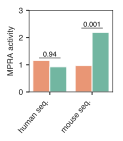

In [37]:
fig = plt.figure(figsize=(1.5, 1.5))

sub = ex[ex["cell"].isin(["HUES64", "mESC"])]
ax = sns.barplot(data=sub, x="seq", y="value", hue="cell", order=order, hue_order=hue_order, palette=pal)
ax.set_xticklabels(["human seq.", "mouse seq."], rotation=50, va="top", ha="right")
ax.set_ylabel("MPRA activity")
ax.set_xlabel("")
ax.get_legend().remove()

ax.set_ylim((0, 3))
annotate_pval(ax, -0.25, 0.25, 1.25, 0, 1.25, ex[ex["variable"] == "fdr_trans_human"]["value"].iloc[0], fontsize-1)
annotate_pval(ax, 0.75, 1.25, 2.35, 0, 2.35, ex[ex["variable"] == "fdr_trans_mouse"]["value"].iloc[0], fontsize-1)

fig.savefig("trans_example_barplot.pdf", dpi="figure", bbox_inches="tight")